#Tensorflow Object Detection with custom dataset in Google Colab

Jupyter notebook providing steps to retrain a [ModelZoo](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md) model with custom dataset.

It runs in [Google Colab](https://colab.research.google.com) using [Tensorflow Object Detection API](https://github.com/tensorflow/models/tree/master/research/object_detection).

**Requirements are only dataset images and annotations file.**

The code is compatible with Object Detection api updates in July 13 2018 [release](https://github.com/tensorflow/models/tree/master/research/object_detection#july-13-2018).

**Colab Runtime type: Python2, GPU enabled.**



#Create Dataset

I generated dataset annotations with [LabelImg](https://github.com/tzutalin/labelImg).

Notebook train a model for one class object detection. It is possible to slightly modify notebook to train model for multiple classes.

Before running notebook, we need to create dataset:

1.   Collect various pictures of objects to detect
2.   Rename image filenames with format `objectclass_seq.jpg`
3.   In LabelImg create annotation files. LabelImg saves annotations as XML files in PASCAL VOC format
4.   Create dataset.zip file having structure defined below
5.   Upload the zip file in your Google Drive

Zip file structure:
```
dataset.zip file
|-images directory
  |-image files (filename format: objectclass_seq.jpg)
|-annotations directory
  |-xmls directory
    |-annotation files (filename format: objectclass_seq.xml)
```

Where `objectclass` is the class name, `seq` is a sequence number (001, 002, 003, ...)

Check my dataset.zip file as dataset example.


In [0]:
# %cd /content
# import shutil
# shutil.rmtree("models")
# shutil.rmtree("../datalab")

/content


In [0]:
# %cd ..
# import os
# os.mkdir("datalab")

/


In [2]:
import tensorflow as tf
tf.__version__

'2.2.0-rc1'

# Install required packages


In [1]:
%cd /content
  
!git clone --quiet https://github.com/tensorflow/models.git

!apt-get install -qq protobuf-compiler python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib PyDrive

!pip install -q pycocotools

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

# print "complete"

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!python object_detection/builders/model_builder_test.py

/content
/content/models/research
2020-03-31 09:51:45.233145: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Traceback (most recent call last):
  File "object_detection/builders/model_builder_test.py", line 23, in <module>
    from object_detection.builders import model_builder
  File "/content/models/research/object_detection/builders/model_builder.py", line 22, in <module>
    from object_detection.builders import box_predictor_builder
  File "/content/models/research/object_detection/builders/box_predictor_builder.py", line 20, in <module>
    from object_detection.predictors import convolutional_box_predictor
  File "/content/models/research/object_detection/predictors/convolutional_box_predictor.py", line 23, in <module>
    slim = tf.contrib.slim
AttributeError: module 'tensorflow' has no attribute 'contrib'


/datalab


# Download and extract dataset


*   Change name attribute in label_map, accordingly with objectclass filename.
*   Substitute fileId value with your dataset.zip id in Google Drive. See [here](https://stackoverflow.com/a/48855034/9250875) my answer to get file id.

In [0]:
%cd /datalab

!echo "item {id: 1 name: 'person'}" > label_map.pbtxt

# 1mpnp9IgtC76xb5OSG0lQb3QadzGohz_U
# 1MSzpTICSbthayUL-GfjvlwIGTA2E_oht
fileId = '1ivguJvCa48YgO7-1LS9JAfTj_rV0NEhl'

import os
from zipfile import ZipFile
from shutil import copy
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fileName = fileId + '.zip'
downloaded = drive.CreateFile({'id': fileId})
downloaded.GetContentFile(fileName)
print(fileName)
# ds = ZipFile(fileName)
# ds.extractall()
# os.remove(fileName)
# print('Extracted zip file ' + fileName)

# image_files=os.listdir('images')
# im_files=[x.split('.')[0] for x in image_files]
# with open('annotations/trainval.txt', 'w') as text_file:
#   for row in im_files:
#     text_file.write(row + '\n')

/datalab
1ivguJvCa48YgO7-1LS9JAfTj_rV0NEhl.zip


In [0]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 25 not upgraded.


In [0]:
!7za


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,4 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Usage: 7za <command> [<switches>...] <archive_name> [<file_names>...]
       [<@listfiles...>]

<Commands>
  a : Add files to archive
  b : Benchmark
  d : Delete files from archive
  e : Extract files from archive (without using directory names)
  h : Calculate hash values for files
  i : Show information about supported formats
  l : List contents of archive
  rn : Rename files in archive
  t : Test integrity of archive
  u : Update files to archive
  x : eXtract files with full paths

<Switches>
  -- : Stop switches parsing
  -ai[r[-|0]]{@listfile|!wildcard} : Include archives
  -ax[r[-|0]]{@listfile|!wildcard} : eXclude archives
  -ao{a|s|t|u} : set Overwrite mode
  -an : disable archive_name field
  -bb[0-3] : set output log level
  -bd : disable progress indicator
  -bs{o|e|p}{0|1|

In [0]:
%cd /datalab

!7za x 1ivguJvCa48YgO7-1LS9JAfTj_rV0NEhl.zip

# os.remove(fileName)
print('Extracted zip file ' + fileName)

image_files=os.listdir('images')
im_files=[x.split('.')[0] for x in image_files]
with open('annotations/trainval.txt', 'w') as text_file:
  for row in im_files:
    text_file.write(row + '\n')

#Empty png files
Create empty png mask files to avoid error in create_pet_tf_record.py, they are not used in training model.

In [0]:
%cd /datalab/annotations

!mkdir trimaps

from PIL import Image
image = Image.new('RGB', (640, 480))

for filename in os.listdir('xmls'):
  filename = os.path.splitext(filename)[0]
  image.save('trimaps/' + filename + '.png')

# Create TFRecord

In [0]:
%cd /datalab

!python ../content/models/research/object_detection/dataset_tools/create_pet_tf_record.py --label_map_path=/datalab/label_map.pbtxt --data_dir=. --output_dir=. --num_shards=1

!mv pet_faces_train.record-00000-of-00001 tf_train.record

!mv pet_faces_val.record-00000-of-00001 tf_val.record


/datalab
W1221 10:42:54.286017 140657100978048 module_wrapper.py:139] From ../content/models/research/object_detection/dataset_tools/create_pet_tf_record.py:318: The name tf.app.run is deprecated. Please use tf.compat.v1.app.run instead.

W1221 10:42:54.286588 140657100978048 module_wrapper.py:139] From /content/models/research/object_detection/utils/label_map_util.py:138: The name tf.gfile.GFile is deprecated. Please use tf.io.gfile.GFile instead.

I1221 10:42:54.287642 140657100978048 create_pet_tf_record.py:273] Reading from Pet dataset.
I1221 10:42:54.291779 140657100978048 create_pet_tf_record.py:288] 1132 training and 486 validation examples.
W1221 10:42:54.291995 140657100978048 module_wrapper.py:139] From /content/models/research/object_detection/dataset_tools/tf_record_creation_util.py:43: The name tf.python_io.TFRecordWriter is deprecated. Please use tf.io.TFRecordWriter instead.

I1221 10:42:54.292198 140657100978048 create_pet_tf_record.py:241] On image 0 of 1132
/content/m

# Download pretrained model

Cell downloads **faster_rcnn_inception_v2_coco** model to use as starting checkpoint.

To use another model from ModelZoo change MODEL var.

In [0]:
%cd /datalab

import os
import shutil
import glob
import urllib
import tarfile

# 'faster_rcnn_inception_v2_coco_2018_01_28'
MODEL = 'ssd_mobilenet_v1_coco_2017_11_17'
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = 'pretrained_model'

if not (os.path.exists(MODEL_FILE)):
  opener = urllib.URLopener()
  opener.retrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
  shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/datalab


# Edit model config file
To you use a different pretrained model in step before, update accordingly filename var and re.sub functions in next cell.


In [0]:
%cd /datalab

import re

#filename = '/content/datalab/pretrained_model/pipeline.config'
filename = '../content/models/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config'
with open(filename) as f:
  s = f.read()
  print("data",s)
with open(filename, 'w') as f:
  # s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/datalab/pretrained_model/model.ckpt', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100', '/content/datalab/tf_train.record', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010', '/content/datalab/tf_val.record', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/datalab/label_map.pbtxt', s)
  # print("*"*40,"\n",s)
  # f.write(s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/datalab/pretrained_model/model.ckpt', s)
  # s = re.sub('/content/datalab/tf_train.record', '/datalab/tf_train.record',s)
  # s = re.sub('/content/datalab/tf_val.record', '/datalab/tf_val.record', s)
  # s = re.sub('/content/datalab/label_map.pbtxt', '/datalab/label_map.pbtxt', s)
  # f.write(s)

  # re.sub('num_classes: 90', 'num_classes: 1', s)
  # re.sub('batch_size: 512', 'batch_size: 10',s)

  #SSD v1 mobilenet coco
  s = re.sub('num_classes: 90', 'num_classes: 1', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/datalab/pretrained_model/model.ckpt', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100','/datalab/tf_train.record' , s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010', '/datalab/tf_val.record', s)
  s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/datalab/label_map.pbtxt', s)
  print("*"*40,"\n")
  print(s)
  f.write(s)

  # s = re.sub('num_classes: 90', 'num_classes: 11', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/model.ckpt', '/content/pretrained_model/model.ckpt', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_train.record-\?\?\?\?\?-of-00100', '/content/train.record', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_val.record-\?\?\?\?\?-of-00010', '/content/val.record', s)
  # s = re.sub('PATH_TO_BE_CONFIGURED/mscoco_label_map.pbtxt', '/content/labels.pbtxt', s)

  # s = re.sub('num_classes: 11', 'num_classes: 1', s)
  # s = re.sub('/content/pretrained_model/model.ckpt', '/datalab/pretrained_model/model.ckpt', s)
  # s = re.sub('/content/train.record','/datalab/tf_train.record' , s)
  # s = re.sub('/content/val.record', '/datalab/tf_val.record', s)
  # s = re.sub('/content/labels.pbtxt', '/datalab/label_map.pbtxt', s)
  # f.write(s)

  # print("*"*40,"\n")
  # print(s)


/datalab
('data', '# SSD with Mobilenet v1 configuration for MSCOCO Dataset.\n# Users should configure the fine_tune_checkpoint field in the train config as\n# well as the label_map_path and input_path fields in the train_input_reader and\n# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that\n# should be configured.\n\nmodel {\n  ssd {\n    num_classes: 90\n    box_coder {\n      faster_rcnn_box_coder {\n        y_scale: 10.0\n        x_scale: 10.0\n        height_scale: 5.0\n        width_scale: 5.0\n      }\n    }\n    matcher {\n      argmax_matcher {\n        matched_threshold: 0.5\n        unmatched_threshold: 0.5\n        ignore_thresholds: false\n        negatives_lower_than_unmatched: true\n        force_match_for_each_row: true\n      }\n    }\n    similarity_calculator {\n      iou_similarity {\n      }\n    }\n    anchor_generator {\n      ssd_anchor_generator {\n        num_layers: 6\n        min_scale: 0.2\n        max_scale: 0.95\n        aspect

# Train model
Set num_train_steps and num_eval_steps values to change train and eval steps in training process.



In [0]:
from datetime import datetime
print(datetime.now())

2019-12-21 10:57:05.917557


In [0]:
%cd /datalab

!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config \
    --model_dir=/content/datalab/trained \
    --alsologtostderr \
    --num_train_steps=20000 \
    --num_eval_steps=500

from datetime import datetime
print(datetime.now())

# %cd /content/models/research/object_detection
# !python model_main.py --logtostderr --train_dir=training/ --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config


/datalab
/content/models/research/object_detection/utils/visualization_utils.py:29: UserWarning: 
This call to matplotlib.use() has no effect because the backend has already
been chosen; matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

The backend was *originally* set to 'module://ipykernel.pylab.backend_inline' by the following code:
  File "/content/models/research/object_detection/model_main.py", line 26, in <module>
    from object_detection import model_lib
  File "/content/models/research/object_detection/model_lib.py", line 27, in <module>
    from object_detection import eval_util
  File "/content/models/research/object_detection/eval_util.py", line 33, in <module>
    from object_detection.metrics import coco_evaluation
  File "/content/models/research/object_detection/metrics/coco_evaluation.py", line 25, in <module>
    from object_detection.metrics import coco_tools
  File "/content/models/research/ob

#Export trained model

Export trained model with highest step number in filename.

In [0]:
%cd /content/datalab

lst = os.listdir('trained')
lf = filter(lambda k: 'model.ckpt-' in k, lst)
last_model = sorted(lf)[-1].replace('.meta', '')

!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path=/content/models/research/object_detection/samples/configs/ssd_mobilenet_v1_coco.config \
    --output_directory=fine_tuned_model1 \
    --trained_checkpoint_prefix=trained/$last_model



/content/datalab
W1221 13:20:36.818519 140660167849856 lazy_loader.py:50] 
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

W1221 13:20:36.935822 140660167849856 module_wrapper.py:139] From /content/models/research/slim/nets/inception_resnet_v2.py:374: The name tf.GraphKeys is deprecated. Please use tf.compat.v1.GraphKeys instead.

W1221 13:20:36.941705 140660167849856 module_wrapper.py:139] From /content/models/research/slim/nets/mobilenet/mobilenet.py:397: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W1221 13:20:36.951498 140660167849856 module_wrapper.py:139] From /content/models/research/object_detection/export_inference_graph.py:162: The na

#Upload jpg image for inference

In [0]:
%cd /datalab

from google.colab import files
from os import path

uploaded = files.upload()
  
for name, data in uploaded.items():
  with open('image1.jpg', 'wb') as f:
    f.write(data)
    f.close()
    print('saved file ' + name)

In [0]:
# https://drop.ndtv.com/albums/AUTO/Hyundai_Grand_i_637025058359468841/637025058359468841_640x480.png

%cd /datalab

# !wget -O "image2.jpg" "https://www.drivespark.com/car-image/640x480x100/car/x16881810-hyundai_grand_i10.jpg.pagespeed.ic.gHyRRjDvhe.jpg"
# !wget -O "image1.jpg" "https://www.ft.com/__origami/service/image/v2/images/raw/https%3A%2F%2Fs3-ap-northeast-1.amazonaws.com%2Fpsh-ex-ftnikkei-3937bb4%2Fimages%2F3%2F3%2F3%2F2%2F3542333-1-eng-GB%2F20161228_Banana-very-popular.jpg?source=nar-cms"
# !wget -O "image1.jpg" "https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR7FuRD4kT4HNpG21Pyv0B2wcdeIMfrfuJJHnllkfr0RN4neQz4yA&s"


/datalab
--2019-12-20 15:16:58--  https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcR7FuRD4kT4HNpG21Pyv0B2wcdeIMfrfuJJHnllkfr0RN4neQz4yA&s
Resolving encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)... 172.217.26.78, 2404:6800:4003:80d::200e
Connecting to encrypted-tbn0.gstatic.com (encrypted-tbn0.gstatic.com)|172.217.26.78|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 15080 (15K) [image/jpeg]
Saving to: ‘image1.jpg’

image1.jpg          100%[===================>]  14.73K  --.-KB/s    in 0s      

2019-12-20 15:16:58 (106 MB/s) - ‘image1.jpg’ saved [15080/15080]



# Run inference


/datalab
--2019-12-21 13:25:39--  https://www.ft.com/__origami/service/image/v2/images/raw/https%3A%2F%2Fs3-ap-northeast-1.amazonaws.com%2Fpsh-ex-ftnikkei-3937bb4%2Fimages%2F3%2F3%2F3%2F2%2F3542333-1-eng-GB%2F20161228_Banana-very-popular.jpg?source=nar-cms
Resolving www.ft.com (www.ft.com)... 151.101.2.109, 151.101.66.109, 151.101.130.109, ...
Connecting to www.ft.com (www.ft.com)|151.101.2.109|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 258275 (252K) [image/jpeg]
Saving to: ‘image1.jpg’

image1.jpg          100%[===================>] 252.22K  --.-KB/s    in 0.03s   

2019-12-21 13:25:39 (8.50 MB/s) - ‘image1.jpg’ saved [258275/258275]

/content/models/research/object_detection


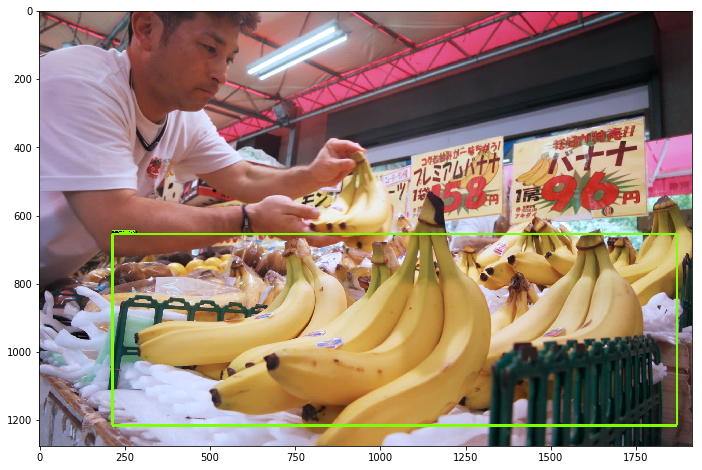

In [0]:
%cd /datalab
# !wget -O "image1.jpg" "https://img.etimg.com/thumb/width-640,height-480,imgsize-489339,resizemode-1,msid-70874692/junk-canned-veggies-fruits-consuming-them-raw-is-better-for-mental-health.jpg"
# !wget -O "image1.jpg" "https://image.freepik.com/free-psd/frame-made-fruits-berries-isolated-white-background_88281-1707.jpg"
# !wget -O "image1.jpg" "https://specials-images.forbesimg.com/imageserve/5de2a028755ebf0006fbd30a/960x0.jpg?fit=scale"
# !wget -O "image1.jpg" "https://www.refinery29.com/images/8985540.jpg?format=webp&width=720&height=864&quality=85"
# !wget -O "image1.jpg" "https://images.indianexpress.com/2019/12/banana_759-1.jpg"
# !wget -O "image1.jpg" "https://images.pexels.com/photos/210019/pexels-photo-210019.jpeg?auto=compress&cs=tinysrgb&dpr=1&w=500"
# !wget -O "image1.jpg" "https://image.shutterstock.com/image-photo/red-apple-on-white-background-260nw-158989157.jpg"
# !wget -O "image1.jpg" "https://www.ft.com/__origami/service/image/v2/images/raw/https%3A%2F%2Fs3-ap-northeast-1.amazonaws.com%2Fpsh-ex-ftnikkei-3937bb4%2Fimages%2F3%2F3%2F3%2F2%2F3542333-1-eng-GB%2F20161228_Banana-very-popular.jpg?source=nar-cms"
# !wget -O "image1.jpg" ""

%cd /content/models/research/object_detection


import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops

# if tf.__version__ < '1.4.0':
#   print tf.__version__
#   raise ImportError('Please upgrade your tensorflow installation to v1.4.* or later!')
  

  
  
# This is needed to display the images.
%matplotlib inline




from utils import label_map_util

from utils import visualization_utils as vis_util




# What model to download.
# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = '/content/datalab/fine_tuned_model1' + '/frozen_inference_graph.pb'

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = os.path.join('/datalab', 'label_map.pbtxt')

NUM_CLASSES = 1




detection_graph = tf.Graph()
with detection_graph.as_default():
  od_graph_def = tf.GraphDef()
  with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
    serialized_graph = fid.read()
    od_graph_def.ParseFromString(serialized_graph)
    tf.import_graph_def(od_graph_def, name='')
    
    
    
    
label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(label_map, max_num_classes=NUM_CLASSES, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




def load_image_into_numpy_array(image):
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)




# If you want to test the code with your images, just add path to the images to the TEST_IMAGE_PATHS.
PATH_TO_TEST_IMAGES_DIR = '/datalab/'
TEST_IMAGE_PATHS = [ os.path.join(PATH_TO_TEST_IMAGES_DIR, 'image{}.jpg'.format(i)) for i in range(1, 2) ]

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)




def run_inference_for_single_image(image, graph):
  with graph.as_default():
    with tf.Session() as sess:
      # Get handles to input and output tensors
      ops = tf.get_default_graph().get_operations()
      all_tensor_names = {output.name for op in ops for output in op.outputs}
      tensor_dict = {}
      for key in [
          'num_detections', 'detection_boxes', 'detection_scores',
          'detection_classes', 'detection_masks'
      ]:
        tensor_name = key + ':0'
        if tensor_name in all_tensor_names:
          tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
              tensor_name)
      if 'detection_masks' in tensor_dict:
        # The following processing is only for single image
        detection_boxes = tf.squeeze(tensor_dict['detection_boxes'], [0])
        detection_masks = tf.squeeze(tensor_dict['detection_masks'], [0])
        # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
        real_num_detection = tf.cast(tensor_dict['num_detections'][0], tf.int32)
        detection_boxes = tf.slice(detection_boxes, [0, 0], [real_num_detection, -1])
        detection_masks = tf.slice(detection_masks, [0, 0, 0], [real_num_detection, -1, -1])
        detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
            detection_masks, detection_boxes, image.shape[0], image.shape[1])
        detection_masks_reframed = tf.cast(
            tf.greater(detection_masks_reframed, 0.5), tf.uint8)
        # Follow the convention by adding back the batch dimension
        tensor_dict['detection_masks'] = tf.expand_dims(
            detection_masks_reframed, 0)
      image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

      # Run inference
      output_dict = sess.run(tensor_dict,
                             feed_dict={image_tensor: np.expand_dims(image, 0)})

      # all outputs are float32 numpy arrays, so convert types as appropriate
      output_dict['num_detections'] = int(output_dict['num_detections'][0])
      output_dict['detection_classes'] = output_dict[
          'detection_classes'][0].astype(np.uint8)
      output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
      output_dict['detection_scores'] = output_dict['detection_scores'][0]
      if 'detection_masks' in output_dict:
        output_dict['detection_masks'] = output_dict['detection_masks'][0]
  return output_dict




for image_path in TEST_IMAGE_PATHS:
  image = Image.open(image_path)
  # the array based representation of the image will be used later in order to prepare the
  # result image with boxes and labels on it.
  image_np = load_image_into_numpy_array(image)
  # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
  image_np_expanded = np.expand_dims(image_np, axis=0)
  # Actual detection.
  output_dict = run_inference_for_single_image(image_np, detection_graph)
  # Visualization of the results of a detection.
  vis_util.visualize_boxes_and_labels_on_image_array(
      image_np,
      output_dict['detection_boxes'],
      output_dict['detection_classes'],
      output_dict['detection_scores'],
      category_index,
      instance_masks=output_dict.get('detection_masks'),
      use_normalized_coordinates=True,
      line_thickness=8)
  plt.figure(figsize=IMAGE_SIZE)
  plt.imshow(image_np)
  

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
from os.path import isdir
isdir('/content/drive/My Drive/MScAI/Sem-3/Project-Sem3/program/Umang/Tensorflow OBJ-DET/Models')

True

In [0]:
!zip -r '/content/drive/My Drive/MScAI/Sem-3/Project-Sem3/program/Umang/Tensorflow OBJ-DET/Models/datalab-1618-20000-bad.zip' '/content/datalab'

  adding: content/datalab/ (stored 0%)
  adding: content/datalab/trained/ (stored 0%)
  adding: content/datalab/trained/model.ckpt-19910.meta (deflated 93%)
  adding: content/datalab/trained/model.ckpt-19910.data-00000-of-00001 (deflated 7%)
  adding: content/datalab/trained/model.ckpt-18392.meta (deflated 93%)
  adding: content/datalab/trained/model.ckpt-20000.data-00000-of-00001 (deflated 7%)
  adding: content/datalab/trained/model.ckpt-20000.meta (deflated 93%)
  adding: content/datalab/trained/model.ckpt-20000.index (deflated 72%)
  adding: content/datalab/trained/events.out.tfevents.1576925915.6be2417df9ea (deflated 93%)
  adding: content/datalab/trained/export/ (stored 0%)
  adding: content/datalab/trained/export/Servo/ (stored 0%)
  adding: content/datalab/trained/export/Servo/1576933825/ (stored 0%)
  adding: content/datalab/trained/export/Servo/1576933825/saved_model.pb (deflated 93%)
  adding: content/datalab/trained/export/Servo/1576933825/variables/ (stored 0%)
  adding: co

###1) Name : datalab-400-30000.zip
### Dataset : 400
### Steps : 30000
### Accuracy : 
### Training time : 6 hrs


### 2) Name : datalab-1618-10000.zip
### Dataset : 1618
### steps : 10000
### Loss : 2.43
### Accuracy : 
### Training time : 2:30 hrs

### 3) Name : datalab-1618-20000-bad.zip
### Dataset : 1618
### steps : 20000
### Loss : 1.56
### Accuracy : 
### Training time : 2:30 hrs
